# Stock Price Prediction (NVIDIA Dataset)


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [6]:
df = pd.read_csv(r"NVDA.csv")
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
data = df[['Close']].values

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [10]:
def create_sequences(data, seq_length=60):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [11]:
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [13]:
X_train = X_train.view(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.view(X_test.shape[0], X_test.shape[1], 1)

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        model = LSTMModel()

In [19]:
# Loss & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
epochs = 20
batch_size = 64

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    epoch_loss = 0
    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        X_batch, y_batch = X_train[indices], y_train[indices]
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(range(0, X_train.size()[0], batch_size)):.6f}")


Epoch 1/20, Loss: 0.000116
Epoch 2/20, Loss: 0.000053
Epoch 3/20, Loss: 0.000001
Epoch 4/20, Loss: 0.000001
Epoch 5/20, Loss: 0.000001
Epoch 6/20, Loss: 0.000001
Epoch 7/20, Loss: 0.000001
Epoch 8/20, Loss: 0.000001
Epoch 9/20, Loss: 0.000001
Epoch 10/20, Loss: 0.000001
Epoch 11/20, Loss: 0.000001
Epoch 12/20, Loss: 0.000001
Epoch 13/20, Loss: 0.000001
Epoch 14/20, Loss: 0.000001
Epoch 15/20, Loss: 0.000001
Epoch 16/20, Loss: 0.000001
Epoch 17/20, Loss: 0.000001
Epoch 18/20, Loss: 0.000001
Epoch 19/20, Loss: 0.000001
Epoch 20/20, Loss: 0.000001


In [21]:
# 6️⃣ Predict
model.eval()
with torch.no_grad():
    train_pred = model(X_train).numpy()
    test_pred = model(X_test).numpy()

In [22]:
# Inverse scale
train_pred_actual = scaler.inverse_transform(train_pred)
y_train_actual = scaler.inverse_transform(y_train.numpy())
test_pred_actual = scaler.inverse_transform(test_pred)
y_test_actual = scaler.inverse_transform(y_test.numpy())

In [23]:
# 7️⃣ Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_actual))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 0.11093441042157379
Test RMSE: 24.660611345891752


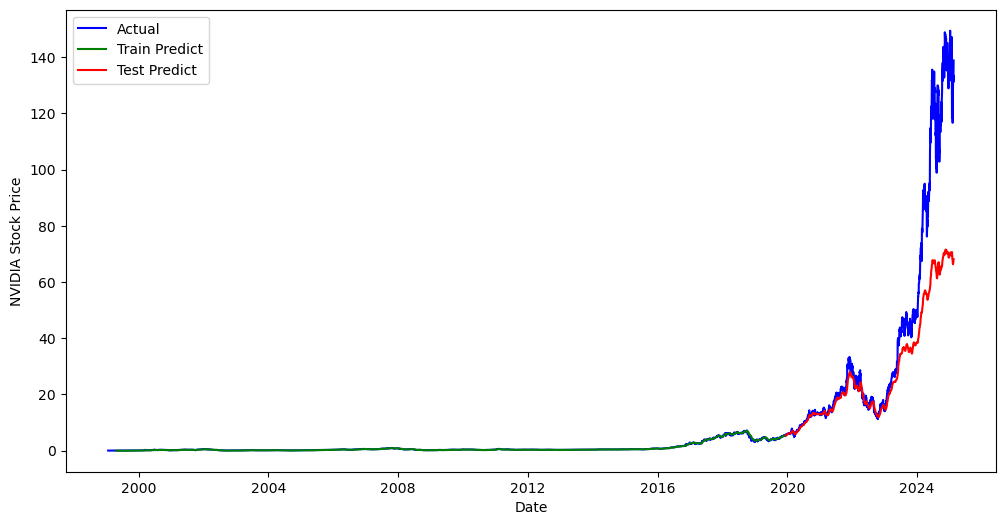

In [24]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Actual', color='blue')
plt.plot(df.index[seq_length:train_size+seq_length], train_pred_actual, label='Train Predict', color='green')
plt.plot(df.index[train_size+seq_length:], test_pred_actual, label='Test Predict', color='red')
plt.xlabel('Date')
plt.ylabel('NVIDIA Stock Price')
plt.legend()
plt.show()

In [32]:
!pip install streamlit



In [33]:
!pip install voila


  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)
   ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
   ------ --------------------------------- 0.8/4.5 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 4.5/4.5 MB 20.4 MB/s eta 0:00:00
Using cached webcolors-24.11.1-py3-none-any.whl (14 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)

   ------ --------------------------------- 1/6 [webcolors]
   --------------------------------- ------ 5/6 [voila]
   --------------------------------- ------ 5/6 [voila]
   ---------------------------------------- 6/6 [voila]



In [34]:
pip install voila
voila your_notebook.ipynb


SyntaxError: invalid syntax (4292430263.py, line 1)